In [27]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
plt.style.use('seaborn')

C:\Users\sergi\AppData\Local\Temp\ipykernel_1624\258415743.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data = pd.read_csv('data/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
#проверяем надичие пропусков
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


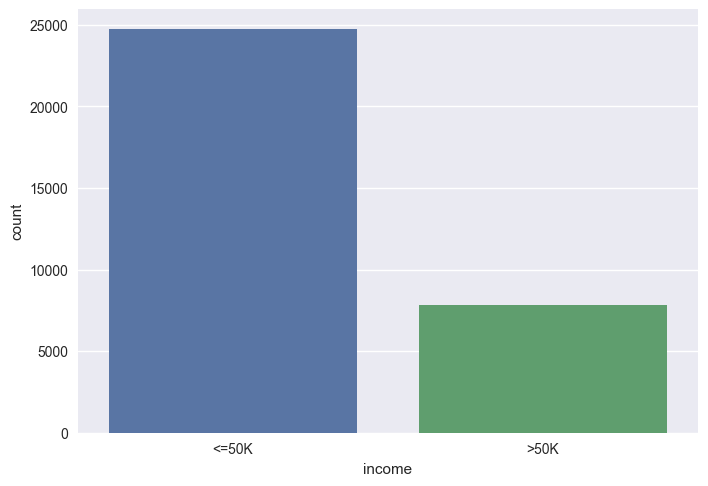

In [5]:
#проверяем данные на сбалансированность
sns.countplot(data=data, x='income');

In [6]:
#переназначем целевой признак
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [7]:
#анализируем категориальные признаки
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

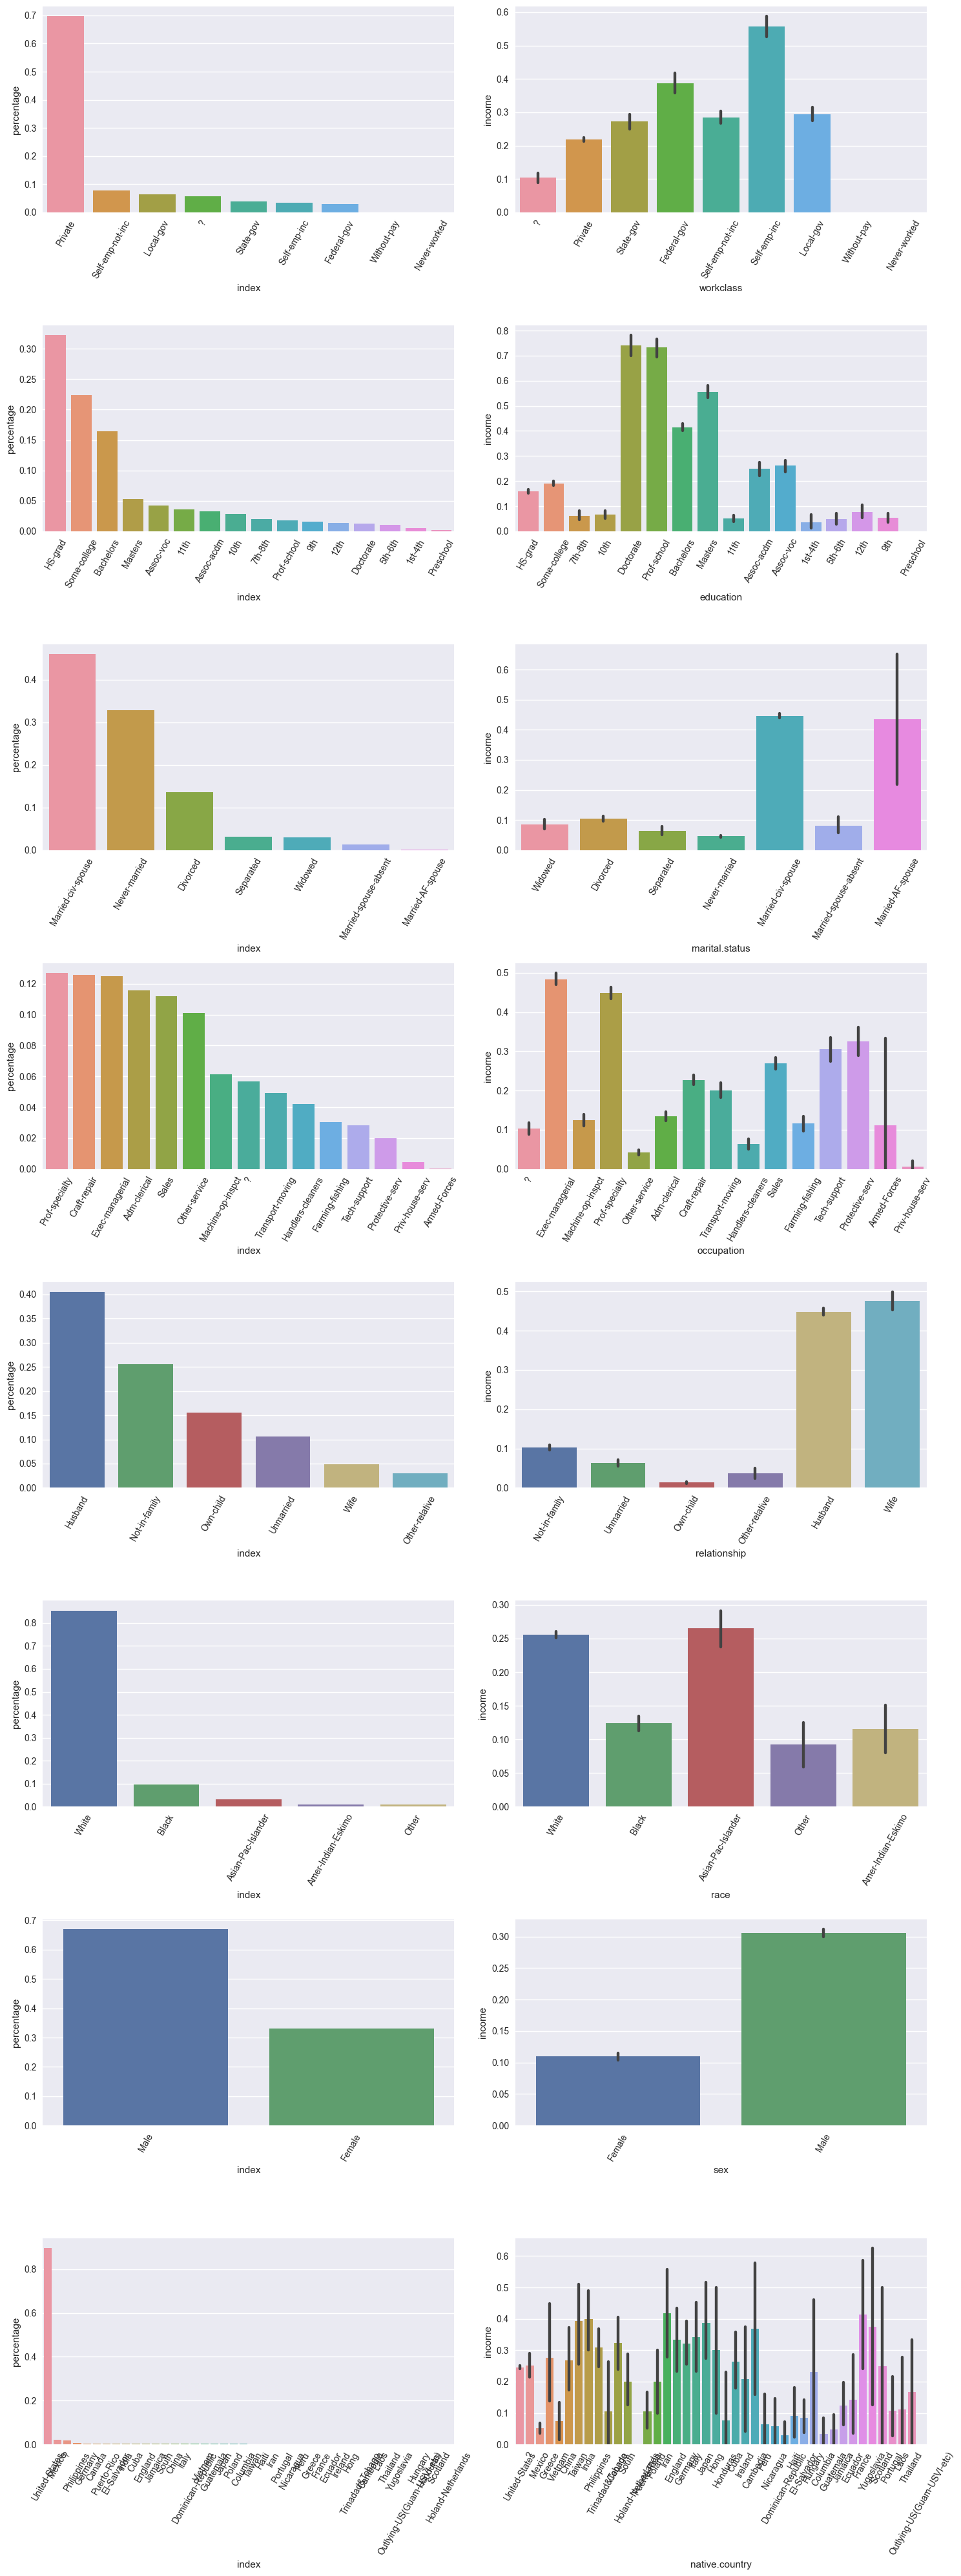

In [8]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

# Предобработка данных

In [9]:
#уменьшаем количество категорий в признаках
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

In [10]:
#предобрабатываем числовые признаки
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [11]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

In [12]:
#проверяем результат
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


C:\Users\sergi\AppData\Local\Temp\ipykernel_1624\2315508478.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(adult_data.corr(), annot = True);


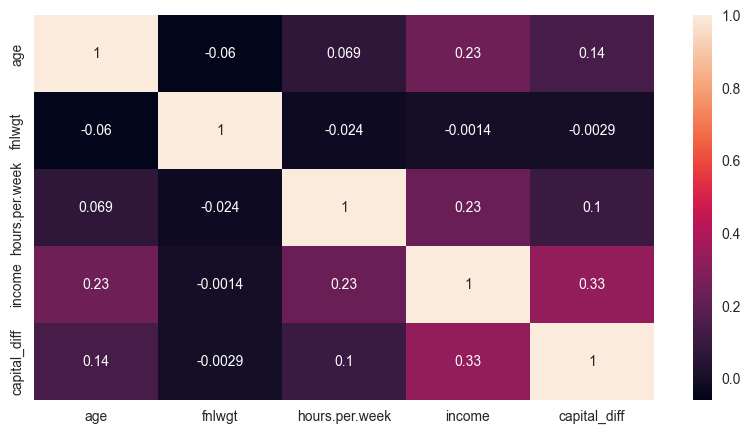

In [13]:
#оцениваем мультиколиниарность
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(), annot = True);

In [14]:
#кодируем текстовые категориальные признаки
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


In [15]:
#разделяем данные на матрицу наблюдений и вектор ответов
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

In [16]:
#разделяем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

In [17]:
#нормализируем данные
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Оптимизация гиперпараметров модели

**Логистическая регрессия**

In [18]:
#построим базовую модель и зафиксируем метрики
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64


**GridSearchCV**

In [20]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


CPU times: total: 703 ms
Wall time: 34.5 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}


In [21]:
#расширим сетку гиперпараметров
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test_scaled, y_test)))
y_test_pred = grid_search_1.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 1.56 s
Wall time: 3min 22s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l2', 'solver': 'lbfgs'}


In [22]:
#смотрим лучшую модель
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=1000, penalty='none', random_state=42)


In [23]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.84


In [24]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.281420,0.022441,0.005022,0.001407,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.838004,0.833781,0.838004,0.839317,0.836437,0.837108,0.001897,51
1,0.554487,0.084119,0.005104,0.002453,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.838004,0.833781,0.838004,0.839317,0.836437,0.837108,0.001897,51


In [25]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

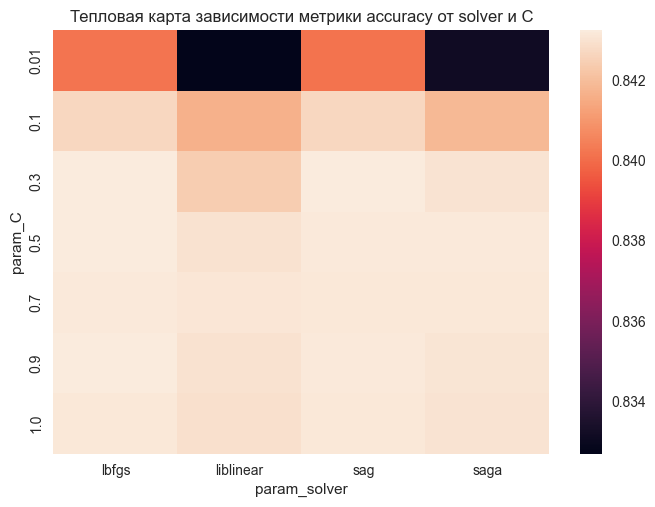

In [26]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

**RandomizedSearchCV**

In [28]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 562 ms
Wall time: 1min 4s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.89}


In [29]:
#сравним с работой метода GridSearch
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 10, 10, dtype=float))},
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_2.score(X_test_scaled, y_test)))
y_test_pred = grid_search_2.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

CPU times: total: 1.39 s
Wall time: 5min 4s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 3.34, 'penalty': 'l2', 'solver': 'lbfgs'}


**Дерево решений**

In [30]:
#оценим базовую модель
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.62


**GridSearch**

In [32]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid,
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 2min 23s
Wall time: 20min 14s
accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.65
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 39}


**RandomSearch**

In [33]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 1.03 s
Wall time: 11.9 s
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.66
Наилучшие значения гиперпараметров: {'min_samples_leaf': 36, 'max_depth': 28, 'criterion': 'entropy'}


**Случайный лес**

In [34]:
#оценим базовую модель
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.66


**GridSearch**

In [35]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test_scaled, y_test)))
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 3.06 s
Wall time: 1min 37s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 110}


**RandomSearch**

In [36]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 3.5 s
Wall time: 49.3 s
f1_score на обучающем наборе: 0.72
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 24}


**Тестовая задача**

In [37]:
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(round(metrics.f1_score(y_train, y_train_pred), 2)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(round(metrics.f1_score(y_test, y_test_pred), 2)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 3.28 s
Wall time: 58.9 s
f1_score на обучающем наборе: 0.70
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 7, 'max_depth': 25}


In [38]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': [10, 15, 20, 25]
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(round(metrics.f1_score(y_train, y_train_pred), 2)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test_scaled, y_test)))
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(round(metrics.f1_score(y_test, y_test_pred), 2)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 3.3 s
Wall time: 2min 53s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
